In [804]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import folium

import datetime

from IPython.core.display import HTML

EARTH_RADIUS = 6371
%matplotlib inline

In [805]:
df = pd.read_csv('pings.csv',header=None,names=['time','acc','lon','lat'])
df.time = pd.to_datetime(df.time, infer_datetime_format=True) + datetime.timedelta(hours=6)
df = df.set_index(df.time)
df.sort_index(inplace=True)
df['dt'] = df.time.diff().astype('<m8[s]').fillna(9999999)
df = df.drop('time',axis=1)
df.head()

,acc,lon,lat,dt
time,,,,
2015-06-01 03:23:27.000000,12,-75.012274,40.283012,9999999
2015-06-01 03:56:20.000000,48,-75.012270,40.282908,1973
2015-06-02 22:36:42.000000,10,100.753538,13.704107,153622
2015-06-02 22:37:47.029999,18,100.757832,13.719487,65
2015-06-02 22:39:15.039000,8,100.749045,13.729378,88


Make a new column with a tuple of lat and lon to make for easier ploting

In [806]:
df['latlon'] = df[['lat','lon']].apply(tuple, axis=1)

Plot all points using folium

In [807]:
def inline_map(m, width=600, height=500):
    """Takes a folium instance and embed HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed

m = folium.Map(location=[df.lat.mean(), df.lon.mean()], zoom_start=5,tiles='OpenStreetMap')
m.line(df.latlon)
for (lat, lon) in df.latlon.sample(1000):
    m.circle_marker(location=[lat,lon])
    
inline_map(m)

Messy! Make some new columns before we clean it up.

In [808]:
def haversine(loc1, loc2):
    lat1, lon1, lat2, lon2 = map(np.radians, [loc1[0],loc1[1],loc2[0],loc2[1]])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    return c * EARTH_RADIUS

def dhaversine(dlat,dlon):
    return haversine((0.0,0.0),(dlat,dlon))

Calculate distances and derivatives

In [877]:
df.sort_index(inplace=True)

#df['dr'] = dhaversine( df.lat.diff(), df.lon.diff() )
#df['dv'] = df.dr.diff()

# Compute dr's by day
# (in case the start recording location is different from the end location the day before)
dr = df.groupby(pd.TimeGrouper('D')).apply(lambda x: dhaversine( x.lat.diff(), x.lon.diff() )).fillna(0)
dr.index = dr.index.droplevel(0)
df['dr'] = dr
df['drdt'] =  df['dr'] / (df.dt/3600)

dv = df.groupby(pd.TimeGrouper('D')).apply(lambda x: x.dr.diff()).fillna(0)
dv.index = dv.index.droplevel(0)
df['dv'] = dv
df['dvdt'] = df['dv'] / (df.dt/3600)

# Cumulative distance by day
df['cumr'] = df.groupby([df.index.month, df.index.day])['dr'].apply(lambda x: x.cumsum())

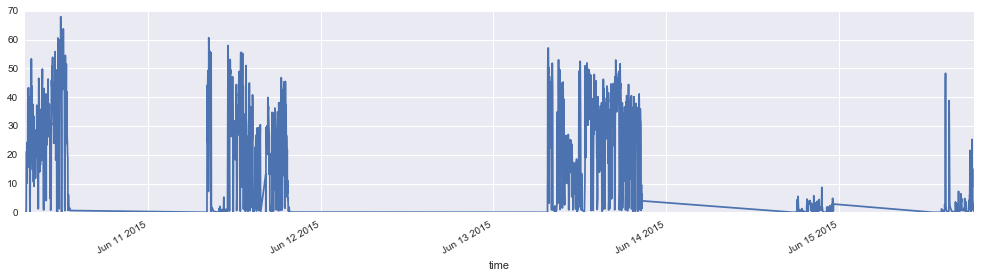

In [878]:
plt.figure(figsize=(17,4))
df['20150610':'20150615'].drdt.plot()
plt.show()

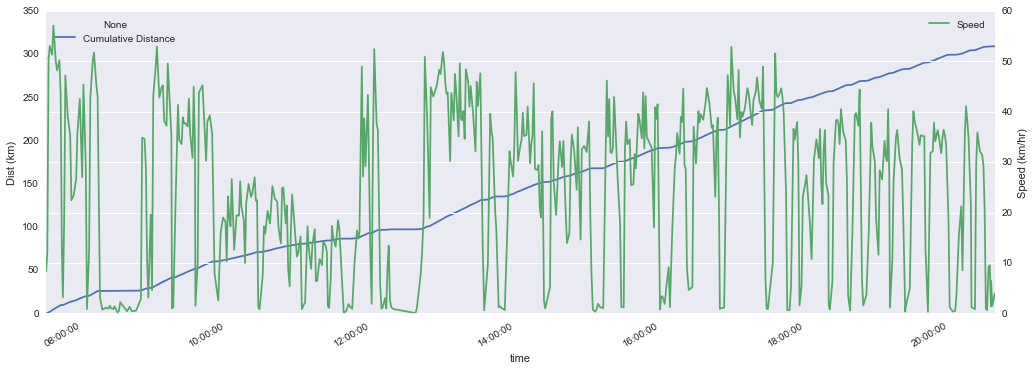

In [879]:
plt.figure(figsize=(17,6))
df['20150613'].iloc[1:].cumr.plot()
plt.ylabel('Dist (km)')
plt.legend(['Cumulative Distance'])
df['20150613'].iloc[1:].drdt.plot(secondary_y=True)
plt.legend(['Speed'])
plt.ylabel('Speed (km/hr)')
plt.show()

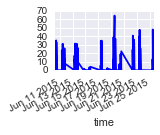

time
2015-06-10 07:00:00     0.000000
2015-06-10 07:00:00     0.001344
2015-06-10 07:00:00     0.048333
2015-06-10 07:00:00     0.379838
2015-06-10 07:00:00     1.078683
2015-06-10 07:00:00     1.694368
2015-06-10 07:00:00     1.917111
2015-06-10 07:00:00     2.328741
2015-06-10 07:00:00     3.079551
2015-06-10 07:00:00     3.384084
2015-06-10 07:00:00     3.730343
2015-06-10 07:00:00     4.389645
2015-06-10 07:00:00     5.115756
2015-06-10 07:00:00     6.111173
2015-06-10 07:00:00     7.499881
2015-06-10 07:00:00     8.221062
2015-06-10 07:00:00     9.085531
2015-06-10 07:00:00     9.706117
2015-06-10 07:00:00    10.776218
2015-06-10 07:00:00    11.163897
2015-06-10 07:00:00    12.344595
2015-06-10 07:00:00    12.905899
2015-06-10 07:00:00    12.918385
2015-06-10 07:00:00    12.919172
2015-06-10 07:00:00    12.939680
2015-06-10 07:00:00    13.268806
2015-06-10 07:00:00    14.413209
2015-06-10 07:00:00    15.087034
2015-06-10 07:00:00    16.441682
2015-06-10 07:00:00    17.992926
     

In [891]:
sday = '20150610'
eday = '20150625'
group = df[sday:eday].groupby(pd.TimeGrouper('H')).apply(lambda x: x.dr.cumsum())
group.index = group.index.droplevel(1)
#group.filter(lambda group: group.index[0] > 0)
# Days with over 50 km traveled
#group = group.filter(lambda group: group.cumr.iloc[-1] > 50.0)
group.plot(subplots=True, layout=(3,3))
plt.show()
group

In [539]:
df['transport'] = np.nan
df['notes'] = np.nan

## Trip lengths

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(....) is deprecated, use sort_index(.....)
/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


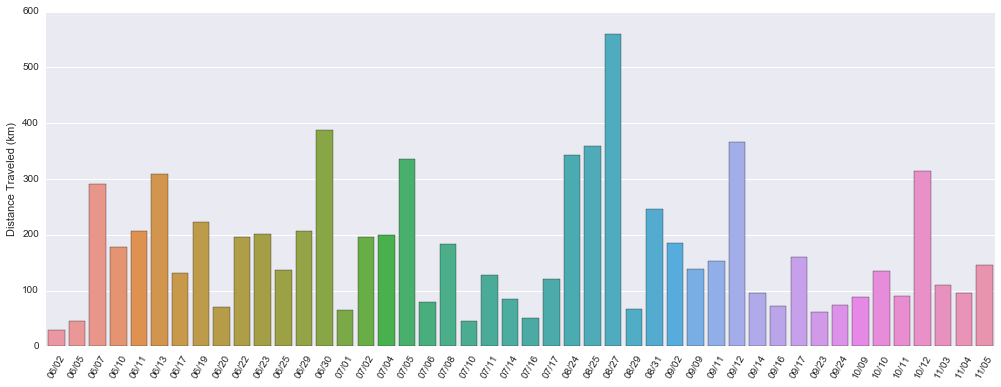

In [881]:
sday = '20150602'
eday = '20151125'
group = df[sday:eday].groupby(pd.TimeGrouper('D'))

plt.figure(figsize=(17,6))
trips = pd.DataFrame(group.dr.agg(sum), index=group.indices).sort()
# Filter extremes
trips = trips[ trips['dr'] > 20]
trips = trips[ trips['dr'] < 600]
# Obnoxious default formatting for dates
date_labels = trips.index.strftime('%m/%d')

sns.barplot(trips.index, trips['dr'])
plt.xticks(rotation=60)
plt.gca().set_xticklabels(date_labels)
plt.ylabel('Distance Traveled (km)')
plt.show()

In [543]:
df['20150610'].head()

,acc,lon,lat,dt,latlon,dr,drdt,dv,dvdt,cumr,label,notes
time,,,,,,,,,,,,
2015-06-10 07:01:20.000000,23,108.434777,11.951552,53139,"(11.951552, 108.434777)",0.039653,0.002686,0.028361,0.001921,0.039653,NaN,NaN
2015-06-10 07:07:02.000000,26,108.434788,11.951557,342,"(11.951557, 108.434788)",0.001344,0.014143,-0.038310,-0.403258,0.040997,NaN,NaN
2015-06-10 07:08:03.000000,25,108.434616,11.951171,61,"(11.951171, 108.434616)",0.046990,2.773154,0.045646,2.693862,0.087986,NaN,NaN
2015-06-10 07:09:04.207000,21,108.435491,11.948321,61,"(11.948321, 108.435491)",0.331505,19.564228,0.284515,16.791074,0.419491,NaN,NaN
2015-06-10 07:11:04.204999,25,108.433364,11.942407,119,"(11.942407, 108.433364)",0.698845,21.141532,0.367340,11.112810,1.118336,NaN,NaN
